# **CS436: Computer Vision Fundamentals**
## Project: Lane Detection

In [1]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
json_gt = [json.loads(line) for line in open('/content/drive/MyDrive/CVF/Project/test_label.json')]

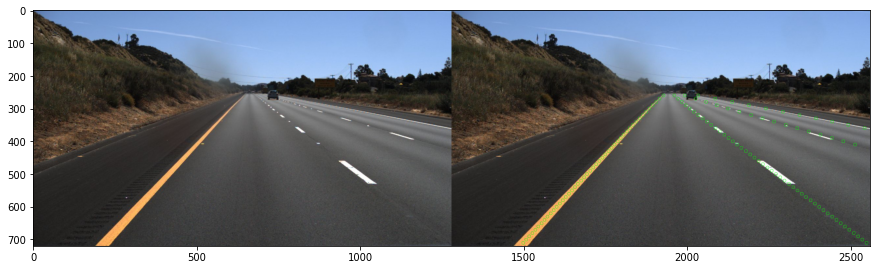

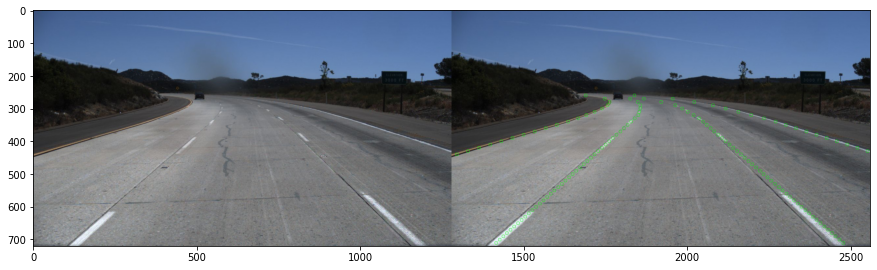

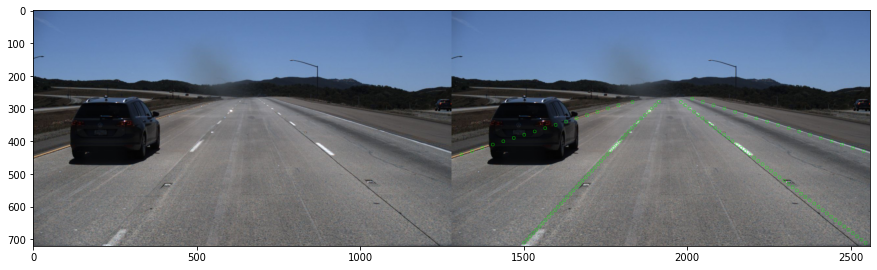

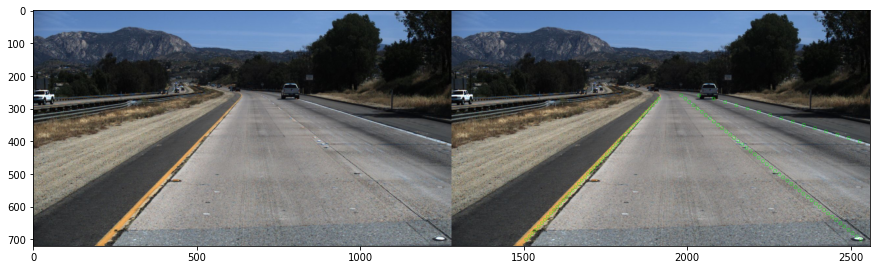

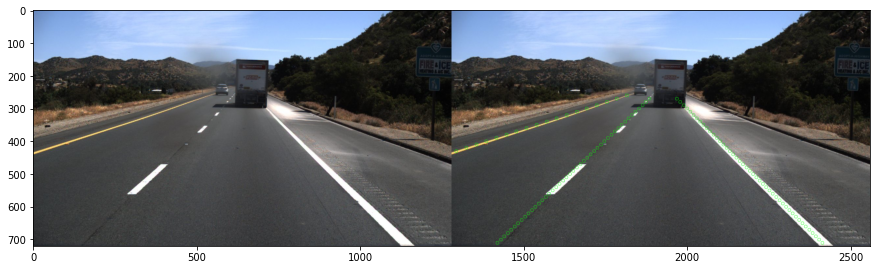

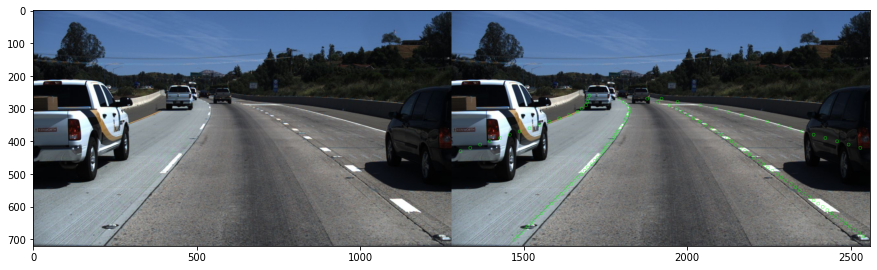

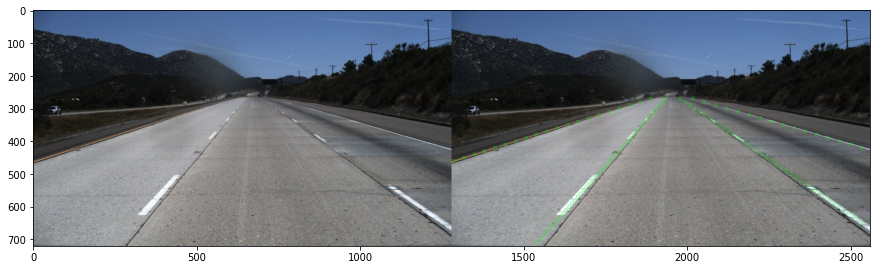

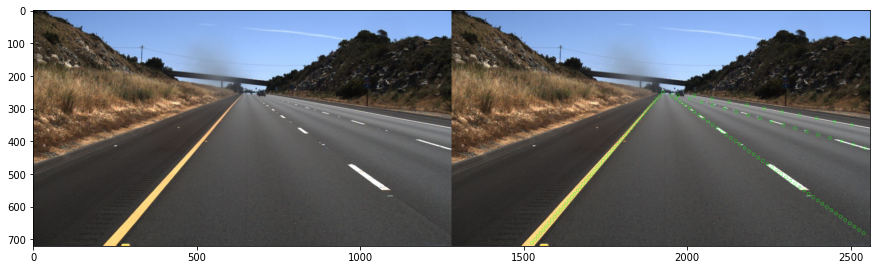

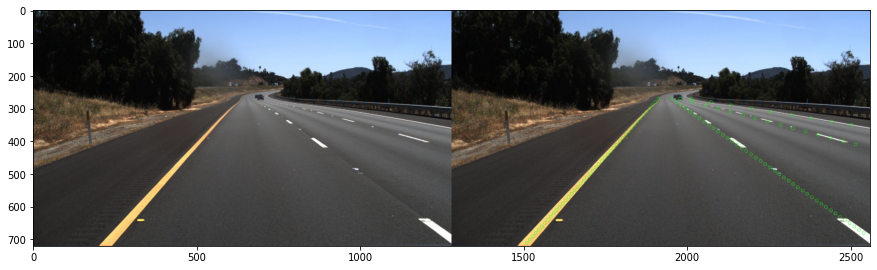

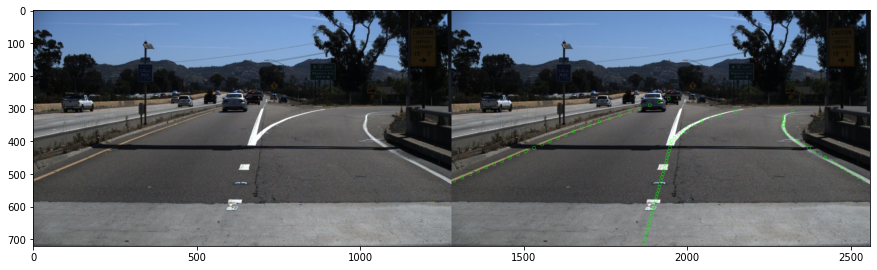

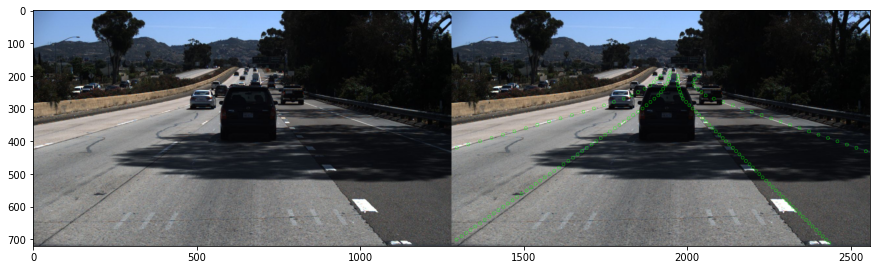

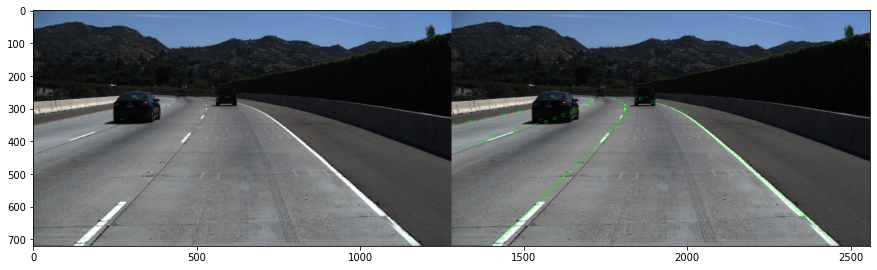

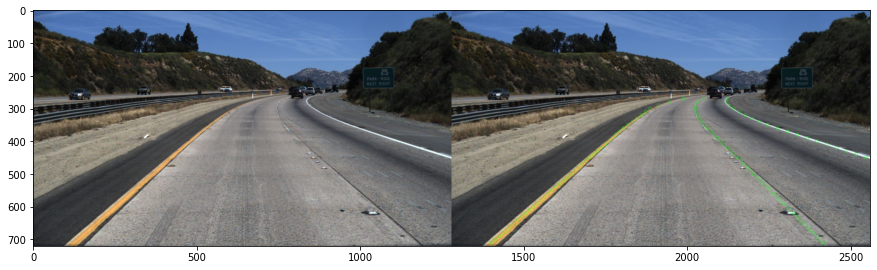

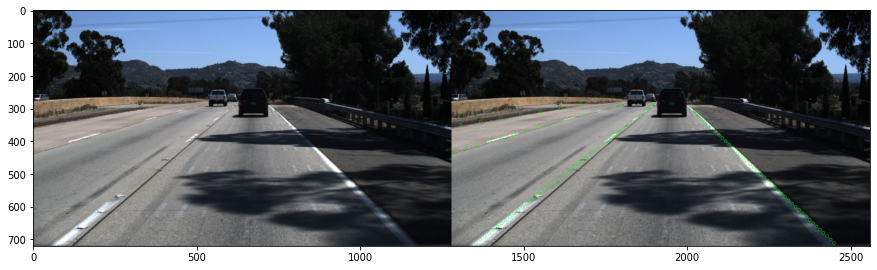

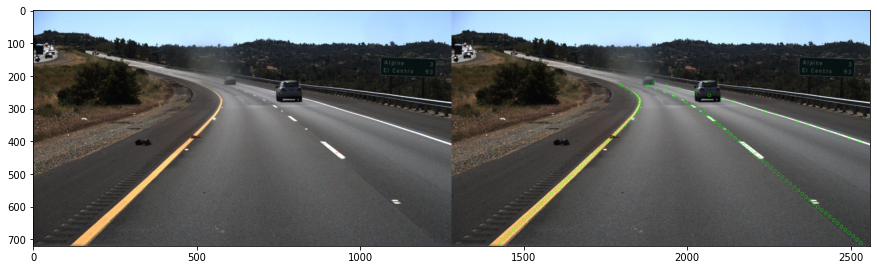

In [ ]:
for i in range(15):
  gt = json_gt[i]
  gt_lanes = gt['lanes']
  y_samples = gt['h_samples']
  raw_file = "/content/drive/MyDrive/CVF/Project/test_set.zip (Unzipped Files)/" + gt['raw_file']
  img = plt.imread(raw_file)

  gt_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples) if x >= 0] for lane in gt_lanes]
  img_vis = img.copy()

  for lane in gt_lanes_vis:
      for pt in lane:
          cv2.circle(img_vis, pt, radius=5, color=(0, 255, 0))

  plt.figure(figsize = (15, 15))
  im_h = cv2.hconcat([img, img_vis])
  plt.imshow(im_h)
  plt.show()

In [3]:
! pip install -r "/content/drive/MyDrive/CVF/Project/lanenet-lane-detection-master/requirements.txt"
! rm -rf "/content/drive/MyDrive/CVF/Project/results/*"

!pip install FastLine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 5.0 MB/s 
     |████████████████████████████████| 411.5 MB 8.7 kB/s 
     |████████████████████████████████| 3.8 MB 62.4 MB/s 
     |████████████████████████████████| 50 kB 8.1 MB/s 
     |████████████████████████████████| 503 kB 60.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=eb9e87b8b79a87ec4eedc850199600491c822d7c3a12f709280cd44d32a64534
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      S

In [4]:
import sys
sys.path.append("/content/drive/MyDrive/CVF/Project/lanenet-lane-detection-master/")

import argparse
import glob
import os
import os.path as ops
import time

import cv2
import numpy as np
import tensorflow as tf
import tqdm

from lanenet_model import lanenet
from lanenet_model import lanenet_postprocess
from local_utils.config_utils import parse_config_utils
from local_utils.log_util import init_logger

from FastLine import Line

CFG = parse_config_utils.lanenet_cfg
LOG = init_logger.get_logger(log_file_name_prefix='lanenet_eval')

In [5]:
input_tensor = tf.placeholder(dtype=tf.float32, shape=[1, 256, 512, 3], name='input_tensor')

net = lanenet.LaneNet(phase='test', cfg=CFG)
binary_seg_ret, instance_seg_ret = net.inference(input_tensor=input_tensor, name='LaneNet')

postprocessor = lanenet_postprocess.LaneNetPostProcessor(cfg=CFG)

saver = tf.train.Saver()

# Set sess configuration
sess_config = tf.ConfigProto()
sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.GPU.GPU_MEMORY_FRACTION
sess_config.gpu_options.allow_growth = CFG.GPU.TF_ALLOW_GROWTH
sess_config.gpu_options.allocator_type = 'BFC'

sess = tf.Session(config=sess_config)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.





In [102]:
def eval_lanenet(src_dir, weights_path, save_dir):

    frames = []
    assert ops.exists(src_dir), '{:s} not exist'.format(src_dir)

    # os.makedirs(save_dir, exist_ok=True)

    with sess.as_default():

        saver.restore(sess=sess, save_path=weights_path)

        image_list = glob.glob('{:s}/**/*.jpg'.format(src_dir), recursive=True)
        avg_time_cost = []
        for index, image_path in tqdm.tqdm(enumerate(image_list), total=len(image_list)):

            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image_vis = image
            image = cv2.resize(image, (512, 256), interpolation=cv2.INTER_LINEAR)
            image = image / 127.5 - 1.0

            t_start = time.time()
            binary_seg_image, instance_seg_image = sess.run(
                [binary_seg_ret, instance_seg_ret],
                feed_dict={input_tensor: [image]}
            )
            avg_time_cost.append(time.time() - t_start)

            postprocess_result = postprocessor.postprocess(
                binary_seg_result=binary_seg_image[0],
                instance_seg_result=instance_seg_image[0],
                source_image=image_vis
            )

            if index % 100 == 0:
                LOG.info('Mean inference time every single image: {:.5f}s'.format(np.mean(avg_time_cost)))
                avg_time_cost.clear()

            input_image_dir = ops.split(image_path.split('clips')[1])[0][1:]
            input_image_name = ops.split(image_path)[1]
            output_image_dir = ops.join(save_dir, input_image_dir)
            os.makedirs(output_image_dir, exist_ok=True)
            output_image_path = ops.join(output_image_dir, input_image_name)

            src_pts = postprocess_result['src_lane_pts']

            img = postprocess_result['source_image'].copy()

            lanes = []
            for lane_pts in src_pts:
              last_five = lane_pts[:5]
              m, b = np.polyfit([i for i,j in last_five], [j for i,j in last_five], 1)
              lane = Line(m=m, b=b)
              n = np.array([m, b])
              lanes.append(lane)

            intersections = []
            for i in range(len(lanes)):
              if i != len(lanes)-1:
                for j in range(i+1, len(lanes), 1):
                  intersections.append(lanes[i].intersection(lanes[j]))
            
            avg_intersection = [0, 0]
            for pt in intersections:
              avg_intersection[0] += pt[0]
              avg_intersection[1] += pt[1]
            
            avg_intersection[0] /= len(intersections)
            avg_intersection[1] /= len(intersections)

            intersection_point = (round(avg_intersection[0]), round(avg_intersection[1]))
            vanishing_point_marked = cv2.circle(img, intersection_point, radius=10, color=(255, 133, 233), thickness=-1)

            # PART 3:
            # plt.figure(figsize=(20,20))
            # plt.imshow(vanishing_point_marked)
            # plt.show()


            # PART 4:
            lane1 = src_pts[0]
            lane2 = src_pts[1]

            idx1 = np.random.randint(-10, -5)
            idx2 = np.random.randint(-25, -20)
            src_pt1 = lane1[idx1]
            src_pt2 = lane1[idx2]

            src_pt3 = None
            src_pt4 = None

            shortest_dist1 = None
            shortest_dist2 = None
          
            for pt in lane2:
              dist1 = abs(src_pt1[1] - pt[1])
              dist2 = abs(src_pt2[1] - pt[1])

              if shortest_dist1 == None or dist1 < shortest_dist1:
                shortest_dist1 = dist1
                src_pt3 = pt

              if shortest_dist2 == None or dist2 < shortest_dist2:
                shortest_dist2 = dist2
                src_pt4 = pt

            cv2.circle(postprocess_result['source_image'], src_pt1, radius=10, color=(255, 133, 233), thickness=-1)
            cv2.circle(postprocess_result['source_image'], src_pt2, radius=10, color=(255, 133, 233), thickness=-1)
            cv2.circle(postprocess_result['source_image'], src_pt3, radius=10, color=(255, 133, 233), thickness=-1)
            cv2.circle(postprocess_result['source_image'], src_pt4, radius=10, color=(255, 133, 233), thickness=-1)

            dst_pt1 = (max(src_pt1[0], src_pt2[0])+20, min(src_pt1[1],src_pt3[1])-20)
            dst_pt2 = (max(src_pt1[0], src_pt2[0])+30, max(src_pt2[1],src_pt4[1])+30)

            dst_pt3 = (min(src_pt3[0], src_pt4[0]-20), min(src_pt1[1],src_pt3[1])-20)
            dst_pt4 = (min(src_pt3[0], src_pt4[0]-30), max(src_pt2[1],src_pt4[1])+30)  

            cv2.circle(postprocess_result['source_image'], dst_pt1, radius=10, color=(0, 255, 255), thickness=-1)
            cv2.circle(postprocess_result['source_image'], dst_pt2, radius=10, color=(0, 0, 255), thickness=-1)

            cv2.circle(postprocess_result['source_image'], dst_pt3, radius=10, color=(255, 255, 255), thickness=-1)
            cv2.circle(postprocess_result['source_image'], dst_pt4, radius=10, color=(0, 0, 0), thickness=-1)   

            src_pts = np.array([src_pt1, src_pt2, src_pt3, src_pt4])
            dst_pts = np.array([dst_pt1, dst_pt2, dst_pt3, dst_pt4])

            H, _ = cv2.findHomography(src_pts, dst_pts)

            result=cv2.warpPerspective(postprocess_result['source_image'], H, (1200,700))
            frames.append(result)

            plt.figure(figsize=(12,12))
            plt.imshow(postprocess_result['source_image'])
            plt.show()

            plt.figure(figsize=(12,12))
            plt.imshow(result)
            plt.show()

            return frames
            # cv2.imwrite(output_image_path, postprocess_result['source_image'])

    return frames

  0%|          | 0/20 [00:00<?, ?it/s]2022-11-28 17:58:46.950 | INFO     | __main__:eval_lanenet:35 - Mean inference time every single image: 0.42396s


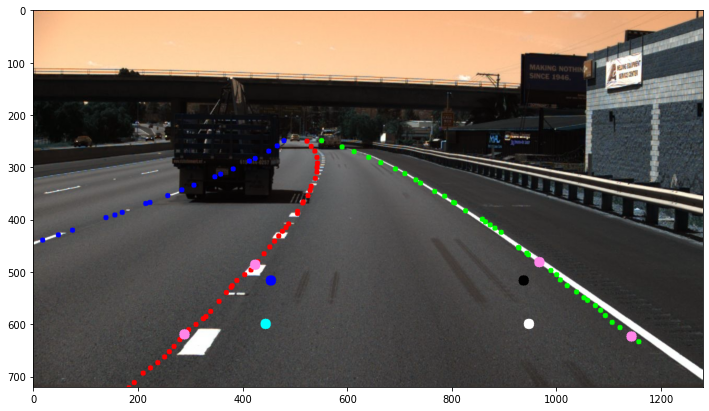

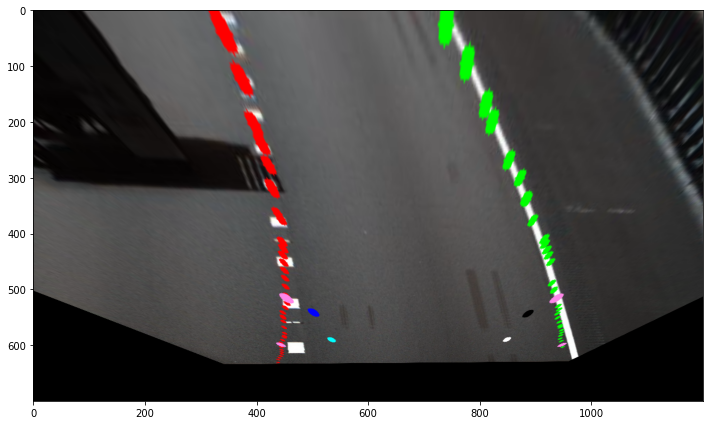

  0%|          | 0/20 [00:01<?, ?it/s]


In [103]:
image_dir = '/content/drive/MyDrive/CVF/Project/test_set.zip (Unzipped Files)/clips/0530/1492626047222176976_0/'
save_dir = "/content/drive/MyDrive/CVF/Project/results/"
weights_path = "/content/drive/MyDrive/CVF/Project/lanenet-lane-detection-master/weights/tusimple_lanenet/tusimple_lanenet.ckpt"

frames = eval_lanenet(src_dir=image_dir, weights_path=weights_path, save_dir=save_dir)

In [99]:
# PART 5
img = cv2.imread(image_dir+"1.jpg")
h,w,c = img.shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('/content/drive/MyDrive/CVF/Project/results/output.mp4', fourcc, 10, (int(w),int(h)))

for f in frames:
  out.write(f)
out.release()